**텐서플로에서 데이터 적재와 전처리하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장: {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 데이터셋

In [2]:
import tensorflow as tf

X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
dataset = tf.data.Dataset.range(10)

In [4]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [5]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [6]:
dataset = dataset.map(lambda x: x * 2)

In [7]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [8]:
dataset = dataset.unbatch()

In [9]:
dataset = dataset.filter(lambda x: x < 10)  # < 10 항목만 유지

In [10]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [11]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 4 5 1 8], shape=(7,), dtype=int64)
tf.Tensor([9 7 1 0 6 4 2], shape=(7,), dtype=int64)
tf.Tensor([3 6 8 7 5 9 1], shape=(7,), dtype=int64)
tf.Tensor([3 2 4 0 6 5 9], shape=(7,), dtype=int64)
tf.Tensor([7 8], shape=(2,), dtype=int64)


## 캘리포니아 주택 데이터셋을 여러 개의 CSV로 나누기

캘리포니아 주택 데이터셋을 로드하고 준비한다. 먼저 로드한 다음 훈련 세트, 검증 세트, 테스트 세트로 나눈다. 마지막으로 스케일을 조정한다:

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1))
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

메모리에 맞지 않는 매우 큰 데이터셋인 경우 일반적으로 먼저 여러 개의 파일로 나누고 텐서플로에서 이 파일들을 병렬로 읽게한다. 데모를 위해 주택 데이터셋을 20개의 CSV 파일로 나누어 본다:

In [13]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join('datasets', 'housing')
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, 'my_{}_{:02d}.csv')
    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, 'wt', encoding='utf-8') as f:
            if header is not None:
                f.write(header)
                f.write('\n')
            for row_idx in row_indices:
                f.write(','.join([repr(col) for col in data[row_idx]]))
                f.write('\n')
    return filepaths

In [14]:
import numpy as np

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ['MedianHouseValue']
header = ','.join(header_cols)
train_filepaths = save_to_multiple_csv_files(train_data, 'train', header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, 'valid', header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, 'test', header, n_parts=10)

좋다. 이 CSV 파일 중 하나에서 몇 줄을 출력해 본다:

In [15]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,2.8594,20.0,4.151458,1.118532,4818.0,4.532455,33.76,-117.91,2.151
1,4.4000,31.0,4.665816,1.168367,719.0,1.834184,34.01,-118.48,3.538
2,2.9871,18.0,5.105000,1.050000,914.0,2.285000,38.23,-122.61,1.938
3,3.9500,52.0,5.025467,1.057725,1191.0,2.022071,37.75,-122.43,3.477
4,3.4449,32.0,5.156200,1.120773,1573.0,2.533011,34.17,-118.43,2.929


텍스트 파일로 읽으면 다음과 같다:

In [16]:
with open(train_filepaths[0]) as f:
    for _ in range(5):
        print(f.readline(), end='')

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
2.8594,20.0,4.151458137347131,1.118532455315146,4818.0,4.532455315145814,33.76,-117.91,2.151
4.4,31.0,4.665816326530612,1.1683673469387754,719.0,1.8341836734693877,34.01,-118.48,3.538
2.9871,18.0,5.105,1.05,914.0,2.285,38.23,-122.61,1.938
3.95,52.0,5.02546689303905,1.0577249575551784,1191.0,2.0220713073005094,37.75,-122.43,3.477


In [17]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

## 입력 파이프라인 만들기

In [18]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths)

In [19]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_18.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_11.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_06.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_04.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', sh

In [20]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers
)

In [21]:
for line in dataset.take(5):
    print(line.numpy())

b'3.7895,29.0,5.323529411764706,1.0661764705882353,1377.0,3.375,37.63,-122.1,1.809'
b'3.3214,52.0,4.825,1.11875,409.0,2.55625,37.77,-122.23,1.896'
b'2.9591,2.0,4.482808022922636,1.012893982808023,1606.0,2.3008595988538683,37.99,-121.96,2.101'
b'3.4837,35.0,4.672316384180791,0.9124293785310734,1065.0,3.0084745762711864,33.78,-117.92,1.865'
b'4.1379,3.0,4.458029197080292,1.1624087591240877,1033.0,1.885036496350365,33.56,-117.7,1.833'


네 번째 필드의 4는 문자열로 해석된다:

In [22]:
record_defaults = [0, np.nan, tf.constant(np.nan, dtype=tf.float64), 'Hello', tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

누락된 값은 제공된 기본값으로 대체된다:

In [23]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

다섯 번째 필드는 필수이다(기본값을 `tf.constant([])`로 지정했기 때문에). 따라서 값을 전달하지 않으면 예외가 발생한다:

In [24]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__DecodeCSV_OUT_TYPE_5_device_/job:localhost/replica:0/task:0/device:CPU:0}} Field 4 is required but missing in record 0! [Op:DecodeCSV]


필드 개수는 `record_defaults`에 있는 필드 개수와 정확히 맞아야 한다:

In [25]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__DecodeCSV_OUT_TYPE_5_device_/job:localhost/replica:0/task:0/device:CPU:0}} Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [26]:
n_inputs = 8  # X_train.shape[-1]


@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [27]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.18846709,  1.21985   , -0.03476744, -0.33513707, -0.5083485 ,
        -0.11295681,  0.88394976, -1.3363829 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [28]:
def csv_reader_dataset(
        filepaths,
        repeat=1,
        n_readers=5,
        n_read_threads=None,
        shuffle_buffer_size=10000,
        n_parse_threads=5,
        batch_size=32
):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads
    )
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [29]:
train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print('X =', X_batch)
    print('y =', y_batch)
    print()

X = tf.Tensor(
[[ 1.4903647  -1.1603684   0.7625442  -0.13509178  1.875858   -0.02328896
  -0.77732414  1.0889348 ]
 [-0.0296825   0.9024875   0.19464988  0.11389511 -0.22687365 -0.07808491
   1.3027972  -1.5071114 ]
 [-0.10190407  0.7438063  -0.23861034 -0.27027956 -0.65478563  0.17272535
  -0.7961474   0.6621193 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.196]
 [2.028]
 [1.104]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-1.0611999   1.8545748   0.57024765  0.42873216 -1.0099175   0.05302301
   1.043959   -1.3865997 ]
 [ 0.5544003   0.188422   -0.33885136 -0.20859395  0.05284751 -0.14013672
  -0.6643756   0.5265441 ]
 [-0.48931313  0.3471032   0.01977106 -0.06033927 -0.4031243  -0.11262911
   0.56393105 -0.12121283]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.85 ]
 [3.117]
 [0.683]], shape=(3, 1), dtype=float32)



In [30]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [31]:
from tensorflow import keras

keras.backend.clear_session()
model = keras.models.Sequential(
    [keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]), keras.layers.Dense(1)]
)

In [32]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [33]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10, validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 4s 7ms/step - loss: 2.3600 - val_loss: 1.1831
Epoch 2/10
362/362 [==============================] - 1s 3ms/step - loss: 0.8488 - val_loss: 0.7839
Epoch 3/10
362/362 [==============================] - 1s 4ms/step - loss: 0.7149 - val_loss: 0.7251
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6843 - val_loss: 0.6853
Epoch 5/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6514 - val_loss: 0.6583
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6306 - val_loss: 0.6340
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6034 - val_loss: 0.6293
Epoch 8/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5823 - val_loss: 0.5985
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5660 - val_loss: 0.5949
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5615 - val_loss: 0.5707

In [34]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.5232


0.5232399702072144

In [35]:
new_set = test_set.map(lambda X, y: X)  # 대신 test_set을 전달할 수 있다. Keras는 레이블을 무시한다.
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

161/161 [==============================] - 0s 1ms/step


array([[2.38468  ],
       [2.0943897],
       [1.4884119],
       ...,
       [2.1783733],
       [1.6286614],
       [2.289695 ]], dtype=float32)

In [36]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print(f'\rGlobal step {global_step}/{total_steps}', end='')
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [37]:
keras.backend.clear_session()

In [38]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error


@tf.function
def train(model, n_epochs, batch_size=32, n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(
        train_filepaths,
        repeat=n_epochs,
        n_readers=n_readers,
        n_read_threads=n_read_threads,
        shuffle_buffer_size=shuffle_buffer_size,
        n_parse_threads=n_parse_threads,
        batch_size=batch_size
    )
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


train(model, 5)

In [39]:
keras.backend.clear_session()

In [40]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error


@tf.function
def train(model, n_epochs, batch_size=32, n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(
        train_filepaths,
        repeat=n_epochs,
        n_readers=n_readers,
        n_read_threads=n_read_threads,
        shuffle_buffer_size=shuffle_buffer_size,
        n_parse_threads=n_parse_threads,
        batch_size=batch_size
    )
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


`Dataset` 클래스에 있는 메서드의 간략한 설명이다:

In [41]:
for m in dir(tf.data.Dataset):
    if not (m.startswith('_') or m.endswith('_')):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, '__doc__'):
            print('● {:21s}{}'.format(m + '()', func.__doc__.split('\n')[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Create

## `TFRecord` 이진 포맷

TFRecord 파일은 단순히 이진 레코드의 리스트이다. `tf.io.TFRecordWriter`를 사용해 만들 수 있다:

In [42]:
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b'This is the first record')
    f.write(b'And this is the second record')

그리고 `tf.data.TFRecordDataset` 사용해 읽을 수 있다.:

In [43]:
filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


하나의 `TFRecordDataset`로 여러 개의 TFRecord 파일을 읽을 수 있다. 기본적으로 한 번에 하나의 파일만 읽지만 `num_parallel_reads=3`와 같이 지정하면 동시에 3개를 읽고 레코드를 번갈아 반환한다:

In [44]:
filepaths = [f'my_test_{i}.tfrecord' for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write(f'File {i} record {j}'.encode('utf-8'))
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [45]:
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('my_compressed.tfrecord', options) as f:
    f.write(b'This is the first record')
    f.write(b'And this is the second record')

In [46]:
dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'], compression_type='GZIP')
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### 프로토콜 버퍼 개요

이 절을 위해서는 [프로토콜 버퍼를 설치](https://developers.google.com/protocol-buffers/docs/downloads)해야 한다. 일반적으로 텐서플로를 사용할 때 프로토콜 버퍼를 설치할 필요는 없다. 텐서플로는 `tf.train.Example` 타입의 프로토콜 버퍼를 만들고 파싱할 수 있는 함수를 제공하며 보통의 경우 충분하다. 하지만 이 절에서는 자체적인 프로토콜 버퍼를 간단히 만들어 보겠다. 따라서 프로토콜 버퍼 컴파일러(`protoc`)가 필요하다. 이를 사용해 프로토콜 버퍼 정의를 컴파일하여 코드에서 사용할 수 있는 파이썬 모듈을 만들겠다.

먼저 간단한 프로토콜 버퍼 정의를 작성해 본다:

In [47]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


이 정의를 컴파일한다(`--descriptor_set_out`와 `--include_imports` 옵션은 아래 `tf.io.decode_proto()`를 위해서 필요하다):

In [48]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [49]:
%ls person*

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: C460-F1D1

 C:\Users\kyun\Desktop\loading_and_preprocessing_data 디렉터리

2022-11-15  오전 11:45                92 person.desc
2022-11-15  오전 11:45               108 person.proto
2022-11-15  오전 11:45               986 person_pb2.py
               3개 파일               1,186 바이트
               0개 디렉터리  111,388,254,208 바이트 남음


In [50]:
from person_pb2 import Person

person = Person(name='Al', id=123, email=['a@b.com'])  # Person 생성
print(person)  # Person 출력

name: "Al"
id: 123
email: "a@b.com"



In [51]:
person.name  # 필드 읽기

'Al'

In [52]:
person.name = 'Alice'  # 필드 수정

In [53]:
person.email[0]  # 배열처럼 사용할 수 있는 반복 필드

'a@b.com'

In [54]:
person.email.append('c@d.com')  # 이메일 추가

In [55]:
s = person.SerializeToString()  # 바이트 문자열로 직렬화
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [56]:
person2 = Person()  # 새로운 Person 생성
person2.ParseFromString(s)  # 바이트 문자열 파싱 (27 바이트)

27

In [57]:
person == person2  # 동일

True

#### 사용자 정의 protobuf

드문 경우에 텐서플로에서 (앞서 만든 것처럼) 사용자 정의 프로토콜 버퍼를 파싱해야 한다. 이를 위해 `tf.io.decode_proto()` 함수를 사용할 수 있다:

In [58]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type='Person',
    field_names=['name', 'id', 'email'],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source='person.desc'
)
person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

더 자세한 내용은 [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) 문서를 참고한다.

### 텐서플로 프로토콜 버퍼

다음이 `tf.train.Example` 프로토콜 버퍼의 정의이다.:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [59]:
from tensorflow.train import Example, Features, Feature, BytesList, Int64List

person_example = Example(
    features=Features(
        feature={
            'name': Feature(bytes_list=BytesList(value=[b'Alice'])),
            'id': Feature(int64_list=Int64List(value=[123])),
            'emails': Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }
    )
)
with tf.io.TFRecordWriter('my_contacts.tfrecord') as f:
    f.write(person_example.SerializeToString())

In [60]:
feature_description = {
    'name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'emails': tf.io.VarLenFeature(tf.string)
}
for serialized_example in tf.data.TFRecordDataset(['my_contacts.tfrecord']):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

In [61]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1faaf6be230>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [62]:
parsed_example['emails'].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [63]:
tf.sparse.to_dense(parsed_example['emails'], default_value=b'')

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [64]:
parsed_example['emails'].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

### TFRecord에 이미지 넣기

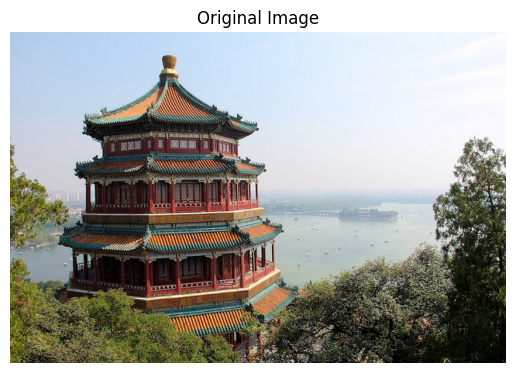

In [65]:
from sklearn.datasets import load_sample_images

img = load_sample_images()['images'][0]
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [66]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={'image': Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
# 그런 다음 TFRecord에 저장

In [67]:
feature_description = {'image': tf.io.VarLenFeature(tf.string)}
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image['image'].values[0])

또는 `decode_image()`를 사용한다. 이 함수는 BMP, GIF, JPEG, PNG 포맷을 지원한다:

In [68]:
decoded_img = tf.io.decode_image(example_with_image['image'].values[0])

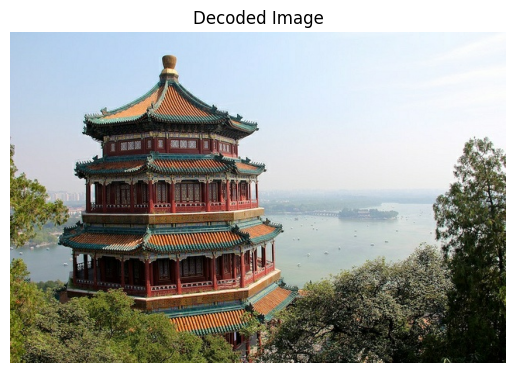

In [69]:
plt.imshow(decoded_img)
plt.title('Decoded Image')
plt.axis('off')
plt.show()

### TFRecord에 텐서와 희소 텐서 넣기

`tf.io.serialize_tensor()`와 `tf.io.parse_tensor()`를 사용해 텐서를 쉽게 직렬화하고 파싱할 수 있다:

In [70]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [71]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [72]:
serialized_sparse = tf.io.serialize_sparse(parsed_example['emails'])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [73]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [74]:
dataset = tf.data.TFRecordDataset(['my_contacts.tfrecord']).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples, feature_description)

In [75]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1faae5e4ee0>}

## `SequenceExample`를 사용해 순차 데이터 다루기

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [76]:
from tensorflow.train import SequenceExample, FeatureLists, FeatureList

context = Features(
    feature={
        'author_id': Feature(int64_list=Int64List(value=[123])),
        'title': Feature(bytes_list=BytesList(value=[b'A', b'desert', b'place', b'.'])),
        'pub_date': Feature(int64_list=Int64List(value=[1623, 12, 25]))
    }
)
content = [
    ['When', 'shall', 'we', 'three', 'meet', 'again', '?'],
    ['In', 'thunder', ',', 'lightning', ',', 'or', 'in', 'rain', '?']
]
comments = [
    ['When', 'the', 'hurlyburly', "'s", 'done', '.'], ['When', 'the', 'battle', "'s", 'lost', 'and', 'won', '.']
]


def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode('utf-8') for word in words]))


content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(
        feature_list={
            'content': FeatureList(feature=content_features), 'comments': FeatureList(feature=comments_features)
        }
    )
)

In [77]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [78]:
serialized_sequence_example = sequence_example.SerializeToString()

In [79]:
context_feature_descriptions = {
    'author_id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'title': tf.io.VarLenFeature(tf.string),
    'pub_date': tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0])
}
sequence_feature_descriptions = {'content': tf.io.VarLenFeature(tf.string), 'comments': tf.io.VarLenFeature(tf.string)}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions, sequence_feature_descriptions
)

In [80]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1faae5a4a30>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [81]:
parsed_context['title'].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [82]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1faae5a6620>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1faae5a6b90>}

In [83]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists['content']))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# 특성 API

이전에 사용했던 캘리포니아 주택 데이터셋에 범주형 특성과 누락된 값이 있으므로 이 데이터를 다시 사용하겠다:

In [84]:
HOUSING_PATH = os.path.join('datasets', 'housing')


def fetch_housing_data(housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [85]:
import tarfile

fetch_housing_data()

In [86]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [87]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [88]:
housing_median_age = tf.feature_column.numeric_column('housing_median_age')

In [89]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std
)

In [90]:
median_income = tf.feature_column.numeric_column('median_income')
bucketized_income = tf.feature_column.bucketized_column(median_income, boundaries=[1.5, 3., 4.5, 6.])

In [91]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [92]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list('ocean_proximity', ocean_prox_vocab)

In [93]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [94]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket('city', hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [95]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]
) # age was scaled
age_and_ocean_proximity = tf.feature_column.crossed_column([bucketized_age, ocean_proximity], hash_bucket_size=100)

In [96]:
latitude = tf.feature_column.numeric_column('latitude')
longitude = tf.feature_column.numeric_column('longitude')
bucketized_latitude = tf.feature_column.bucketized_column(latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1))
)
location = tf.feature_column.crossed_column([bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [97]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [98]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity, dimension=2)

## `feature_column`을 사용해 파싱하기

In [99]:
median_house_value = tf.feature_column.numeric_column('median_house_value')

In [100]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [101]:
from tensorflow.train import FloatList

with tf.io.TFRecordWriter('my_data_with_features.tfrecords') as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(
            features=Features(
                feature={
                    'housing_median_age': Feature(float_list=FloatList(value=[x])),
                    'median_house_value': Feature(float_list=FloatList(value=[y]))
                }
            )
        )
        f.write(example.SerializeToString())

In [102]:
keras.backend.clear_session()

In [103]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop('median_house_value')  # separate the targets)
    return examples, targets


batch_size = 32
dataset = tf.data.TFRecordDataset(['my_data_with_features.tfrecords'])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

In [104]:
columns_without_target = columns[:-1]
inputs = {columns_without_target[0].key: tf.keras.Input(shape=[])}
features = keras.layers.DenseFeatures(feature_columns=columns_without_target)(inputs)
outputs = keras.layers.Dense(1)(features)
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['mae'])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
362/362 [==============================] - 1s 3ms/step - loss: 4.9336 - mae: 1.7790
Epoch 2/5
362/362 [==============================] - 1s 3ms/step - loss: 2.1522 - mae: 1.1202
Epoch 3/5
362/362 [==============================] - 1s 3ms/step - loss: 1.4967 - mae: 0.9171
Epoch 4/5
362/362 [==============================] - 1s 3ms/step - loss: 1.3481 - mae: 0.8866
Epoch 5/5
362/362 [==============================] - 1s 3ms/step - loss: 1.3367 - mae: 0.8970


In [105]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({'ocean_proximity': [['NEAR OCEAN'], ['INLAND'], ['INLAND']], 'median_income': [[3.], [7.2], [1.]]})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.38614446,  0.48583168],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.1640503 , -0.27387664],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.1640503 , -0.27387664]], dtype=float32)>

# TF 변환

In [106]:
try:
    import tensorflow_transform as tft


    def preprocess(inputs):  # inputs = 입력 특성의 배치
        median_age = inputs['housing_median_age']
        ocean_proximity = inputs['ocean_proximity']
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {'standardized_median_age': standardized_age, 'ocean_proximity_id': ocean_proximity_id}
except ImportError:
    print('TF Transform is not installed. Try running: pip3 install -U tensorflow-transform')

TF Transform is not installed. Try running: pip3 install -U tensorflow-transform


# 텐서플로 데이터셋

In [107]:
import tensorflow_datasets as tfds

datasets = tfds.load(name='mnist')
mnist_train, mnist_test = datasets['train'], datasets['test']

In [108]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'bair_robot_pushing_small', 'bccd', 'beans', 'bee_dataset', 'beir', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bucc', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cardiotox', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar100_n', 'cifar10_1', 'cifar10_corrupted', 'cifar10_n', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'conll2003', 'controlled_noisy_web_labels', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d', 'criteo', 'cs_restaur

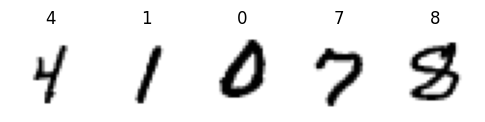

In [109]:
plt.figure(figsize=(6, 3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item['image']
    labels = item['label']
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap='binary')
        plt.title(label)
        plt.axis('off')
    break  # 첫 번째 배치의 일부만 표시

In [110]:
datasets = tfds.load(name='mnist')
mnist_train, mnist_test = datasets['train'], datasets['test']
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items['image'], items['label']))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [111]:
keras.backend.clear_session()

In [112]:
datasets = tfds.load(name='mnist', batch_size=32, as_supervised=True)
mnist_train = datasets['train'].repeat().prefetch(1)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
        keras.layers.Dense(10, activation='softmax')
    ]
)
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy']
)
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 31.5818 - accuracy: 0.8425
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 26.0088 - accuracy: 0.8679
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.8515 - accuracy: 0.8740
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.0269 - accuracy: 0.8757
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.2343 - accuracy: 0.8766


# 텐서플로 허브

In [113]:
keras.backend.clear_session()

In [114]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer(
    'https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1', output_shape=[50], input_shape=[], dtype=tf.string
)
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [115]:
sentences = tf.constant(['It was a great movie', 'The actors were amazing'])
embeddings = hub_layer(sentences)

In [116]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       

# 연습

## 1.
### a.
_패션 MNIST 데이터셋을 적재하고 훈련 세트, 검증 세트, 테스트 세트로 나눈다. 훈련 세트를 섞은 다음 각 데이터셋을 TFRecord 파일로 저장한다. 각 레코드는 두 개의 특성을 가진 `Example` 프로토콜 버퍼, 즉 직렬화된 이미지(`tf.io.serialize_tensor()`를 사용해 이미지를 직렬화한다)와 레이블이다. 참고: 용량이 큰 이미지일 경우 `tf.io.encode_jpeg()`를 사용할 수 있다. 많은 공간을 절약할 수 있지만 이미지 품질이 손해를 본다._

In [127]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [128]:
keras.backend.clear_session()

In [129]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [130]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    # image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                'label': Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

In [131]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

다음 함수는 주어진 데이터셋을 일련의 TFRecord 파일로 저장한다. 이 코드는 라운드-로빈 방식으로 파일에 저장한다. 이를 위해 `dataset.enumerate()` 메서드로 모든 샘플을 순회하고 저장할 파일을 결정하기 위해 `index % n_shards`를 계산한다. 표준 `contextlib.ExitStack` 클래스를 사용해 쓰는 동안 I/O 에러의 발생 여부에 상관없이 모든 `writer`가 적절히 종료되었는지 확인한다.

In [200]:
def write_tfrecords(name, dataset, n_shards=10):
    paths = [f'{name}.tfrecord-{index:05d}-of-{n_shards:05d}' for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index.numpy() % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [201]:
from contextlib import ExitStack

train_filepaths = write_tfrecords('my_fashion_mnist.train', train_set)
valid_filepaths = write_tfrecords('my_fashion_mnist.valid', valid_set)
test_filepaths = write_tfrecords('my_fashion_mnist.test', test_set)